# Pynams: A Python Package for Nominally Anhdydrous Minerals
An example of processing FTIR spectra with [pynams](https://github.com/EFerriss/pynams)

## Get pynams and basic python scientific and plotting packages
pynams is written in Python 2.7 and requires the [lmfit](https://pypi.python.org/pypi/lmfit/)
and [uncertainties](https://pythonhosted.org/uncertainties/) packages. For those new to python, I recommend downloading [anaconda](https://www.continuum.io/downloads). If you are used to Matlab, check out [spyder](https://pythonhosted.org/spyder/), which comes with anaconda.

In [2]:
%matplotlib inline
from pynams import pynams
import numpy as np
import matplotlib.pyplot as plt

## Create a spectrum object
The core structure you need to understand to handle FTIR spectra with pynams is a class called Spectrum. Each of your FTIR spectra will have to be created as an object, and pynams.Spectrum is the class, or template, for making these objects. Each Spectrum object then by default has attributes like thickness and the ability to create and save baselines. 

Each FTIR spectrum **requires** information about the sample thickness **in microns** (thick_microns), a short descriptive name (fname), and the location of the file containing the data. Currently only .CSV files are supported, but other formats can be added easily or upon request. The spectrum's fname should be the same as the filename without the extension. So if your spectrum is saved as pynamsDemo.CSV, the spectrum's fname should be the string 'pynamsDemo'.

Here in the first line I create a particular spectrum ("instantiate the class Spectrum" in object-oriented parlance), which I call spectrum, and I specify the fname and thickness while creating it.

This spectrum also needs to know where to find data from the file pynamsDemo.CSV. 

In [3]:
spectrum = pynams.Spectrum(fname = 'pynamsDemo', thick_microns = 876.4)

FTIR_file_location = 'C:\\Users\\Ferriss\\Documents\\FTIR\\'

# Get test data from the web and save it to the specified folder.
import requests
r = requests.get('https://raw.githubusercontent.com/EFerriss/HydrogenCpx/master/FTIR_CSV_FILES/P_0_unpol.CSV')
workfile = ''.join((FTIR_file_location, spectrum.fname,'.CSV'))
with open(workfile, 'w') as f:
    f.write(r.content)

# Make the filename
# Option 1: Specify the spectrum's filename explicitly
# spectrum.filename = FTIR_file_location + spectrum.fname + '.CSV'

# Option 2: Use the pynams built-in function make_filenames. 
# This option is very handy when you have more than one spectrum.
pynams.make_filenames(folder=FTIR_file_location, file_ending='.CSV') 

## Plotting spectra
You can look at the spectrum by calling the method plot_spectrum. This function returns handles for the figure and axis, which you can then save or adjust as with any other figure generated using matplotlib. To show another spectrum on the same axis, use the argument figaxis. You can also specify the style (my favorites are stored in pynams.styles) and set labels for making legends. 

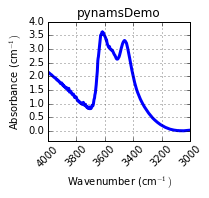

In [4]:
fig, ax = spectrum.plot_spectrum()

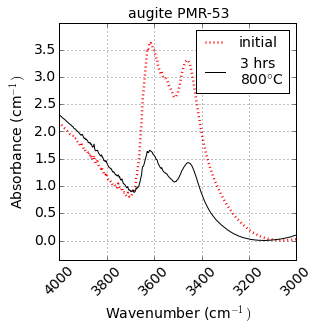

In [5]:
# Making second spectrum called spectrum2 
spectrum2 = pynams.Spectrum(fname = 'pynamsDemo2', thick_microns = 876.4)
r = requests.get('https://raw.githubusercontent.com/EFerriss/HydrogenCpx/master/FTIR_CSV_FILES/P_6_unpol.CSV')
workfile = ''.join((FTIR_file_location, spectrum2.fname,'.CSV'))
with open(workfile, 'w') as f:
    f.write(r.content)
pynams.make_filenames(folder=FTIR_file_location)

# A more elaborate plot with two spectra
fig, ax = spectrum.plot_spectrum(style=pynams.styles.style_initial, label='initial')
spectrum2.plot_spectrum(figaxis=ax, style=pynams.styles.style_1, label='3 hrs\n800$\degree$C')
fig.set_size_inches(5, 5)
ax.set_title('augite PMR-53', fontsize=14)
hleg = ax.legend(loc=1, fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=14)
ax.xaxis.label.set_size(14)
ax.yaxis.label.set_size(14)

## Making baselines
The default is a line between wavenumbers 3200 and 3700 cm-1, but you can also make quadratic baselines and change the wavenumber range. Here are three examples:

Making baseline...


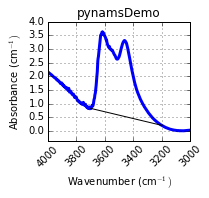

In [6]:
fig, ax = spectrum.plot_showbaseline()

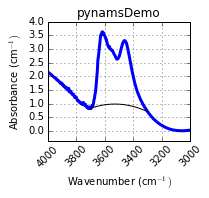

In [7]:
spectrum.base_low_wn = 3300
baseline = spectrum.make_baseline(line_order=2, shiftline=-0.2, show_plot=True)

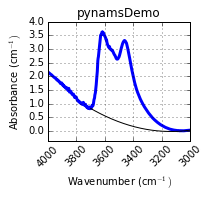

In [8]:
spectrum.base_low_wn = 3000
baseline = spectrum.make_baseline(line_order=2, shiftline=0.3, show_plot=False)
fig, ax = spectrum.plot_showbaseline()

## Subtracting the baseline

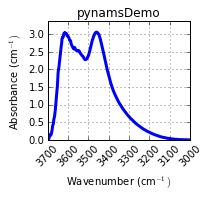

In [9]:
fig, ax = spectrum.plot_subtractbaseline()

## Saving baselines
The method save_baseline() creates a new file fname-baseline.CSV containing the baseline and baseline-subtracted spectrum normalized per cm.

In [10]:
spectrum.save_baseline(folder=FTIR_file_location)

using existing baseline
Saving pynamsDemo-baseline.CSV


## Retrieving saved baseline information

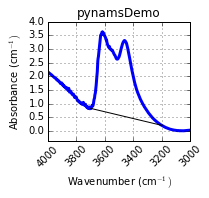

In [11]:
# Get previously generated baseline information from the web
r = requests.get('https://raw.githubusercontent.com/EFerriss/HydrogenCpx/master/FTIR_CSV_FILES/baselines/P_0_unpol-baseline.CSV')
workfile = ''.join((FTIR_file_location, spectrum.fname, '-baseline.CSV'))
with open(workfile, 'w') as f:
    f.write(r.content)

baseline_data = spectrum.get_baseline(folder=FTIR_file_location)
fig, ax = spectrum.plot_showbaseline()

## Estimating peak area and water concentration
Right now only the mineral-specific area calibrations from Bell et al. 1995 for clinopyroxene (phase_name='cpx'; the default because that's what I, Elizabeth Ferriss, happen to work on) and Bell&Rossman 2003 for olivine (mineral_name='olivine') are included, but other calibrations (Paterson, wavenumber-specific, other minerals) can be added either by me upon request, or, because the code is open source, by you, dear reader.

For this simple case, the water concentration returned is just the area between the curve and baseline multiplied by the integral specific absorption coefficient, and the error is propogated only from the error on that absorption coefficient. Ideally one would add up these areas from spectra polarized in three orthogonal directions (Libowitzky&Rossman, 1996). 

Using previously fit baseline. Use make_baseline to change it.


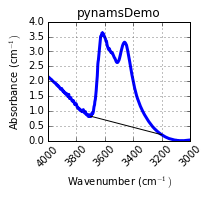

pynamsDemo
area: 719.1 /cm^2
water: 101.4+/-4.6 ppm H2O; *3 = 304.3+/-13.7 ppm H2O


In [12]:
area, water = spectrum.water(phase_name='cpx', show_plot=True)

## Peak fitting
I am unfortunately not aware of any good peak fitting programs currently available in python. The peak fitting program that I use is an open-source program available for Matlab and Octave called [peakfit.m](https://terpconnect.umd.edu/~toh/spectrum/InteractivePeakFitter.htm#command). Another option I am aware of is OpticalFit, which was developed by and is available from CSIRO Australia.

My strategy is as follows:  
1. Make and save the baseline using pynams as described above.
2. Perform a peak fitting routine on the baseline-subtracted spectrum in Matlab using peakfit.m, usually called through this [helper function](https://github.com/EFerriss/pynams/blob/master/matlab_helper_files/FTIR_peakfit_loop.m) that loops through spectra fnames and allows setting individual peak widths and heights.
3. At the end of FTIR_peakfit_loop.m call another matlab function to [save the fit](https://github.com/EFerriss/pynams/blob/master/matlab_helper_files/savefit.m) details as fname-peakfit.CSV
4. Back in python, retrieve the saved peakfit information using pynams.Spectrum.get_peakfit()


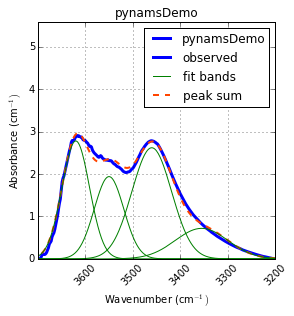

In [13]:
# Get previously generated peakfit information file from the web
r = requests.get('https://raw.githubusercontent.com/EFerriss/HydrogenCpx/master/FTIR_CSV_FILES/peakfits/P_0_unpol-peakfit.CSV')
workfile = ''.join((FTIR_file_location, spectrum.fname, '-peakfit.CSV'))
with open(workfile, 'w') as f:
    f.write(r.content)

fig, ax = spectrum.plot_peakfit()
fig.set_size_inches(5, 5)
# To get the curve information details, use 
# peakfitcurves, summed_spectrum = spectrum.get_peakfit()
